# Preprocessing

In [1]:
import pdfminer
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import re
import string
import gensim
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from nltk.stem.snowball import SnowballStemmer

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('phishing_site_urls.csv')

df.columns = [x.lower() for x in df.columns]
df['Y'] = df['label'].apply(lambda x: 0 if x == 'good' else 1)

In [3]:
def url_process(url):
    url = re.sub('[^a-zA-Z\ \n]', '.', url.lower())
    url =  re.sub('\.{1,}', ' ', url)
    url = url.split(' ')
    
    stemmer = SnowballStemmer("english")
    url = [stemmer.stem(word) for word in url]
    url = ' '.join(url)
    return url

df['url_clean'] = df['url'].apply(url_process)

# Feature extraction using CountVectorizer

In [4]:
cv=CountVectorizer(ngram_range=(1, 2))

X_train, X_test, y_train, y_test = train_test_split(df['url_clean'], df['Y'], test_size=0.2, random_state=5555)

cv_fit = cv.fit(X_train)
X_train = cv_fit.transform(X_train)

X_test = cv_fit.transform(X_test)

#  LogisticsRegression Model

In [5]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
lg.fit(X_train, y_train)
pred = lg.predict(X_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     78641
           1       0.97      0.94      0.96     31229

    accuracy                           0.98    109870
   macro avg       0.98      0.96      0.97    109870
weighted avg       0.98      0.98      0.98    109870



## Hyperparameter tuning

In [6]:
%%time
from sklearn.model_selection import GridSearchCV
grid = {'C': [0.001, 0.01, 0.1, 1, 10],
       'penalty':['l1','l2'],
       'solver':['newton-cg', 'lbfgs', 'liblinear']}

lg = LogisticRegression()
clf = GridSearchCV(estimator=lg,
                   param_grid=grid)
clf.fit(X_train,y_train)

# Print hyperparameter
print("Tuned hyperparameter parameters: {}".format(clf.best_params_)) 
print("Best cross-validation score: {}".format(clf.best_score_))



KeyboardInterrupt: 

In [6]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(C=10,penalty='l2',solver='lbfgs')
lg.fit(X_train, y_train)
pred_lg = lg.predict(X_test)
print(classification_report(y_test,pred_lg))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     78641
           1       0.98      0.96      0.97     31229

    accuracy                           0.98    109870
   macro avg       0.98      0.97      0.98    109870
weighted avg       0.98      0.98      0.98    109870




CONFUSION MATRIX


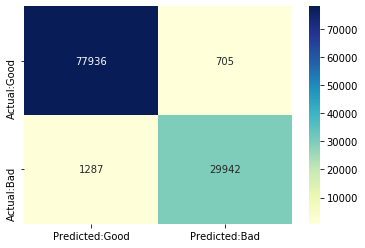

In [8]:
con_mat = pd.DataFrame(confusion_matrix(y_test,lg.predict(X_test)),
            columns = ['Predicted:Good', 'Predicted:Bad'],
            index = ['Actual:Good', 'Actual:Bad'])


print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

# Save model in pickle format

In [28]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(C=10,
                       penalty='l2',
                       solver='lbfgs')

lg.fit(X_train, y_train)


LogisticRegression(C=10)

In [32]:
def new_input(url):
    a = url_process(url)
    a_trans = cv_fit.transform(pd.Series(a))
    model_pred = lg.predict(a_trans)
    if model_pred ==1:
        return 'Warning! Site highly likely to be a phishing link! Proceed with caution!'
    else:
        return 'Great! Site is likely to be safe!'

In [33]:
# new_test = 'www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrcmd=_home-customer&nav=1/loading.php'
# new_input(new_test)

In [39]:
import pickle
filename = 'phishing-link-detection.sav'
pickle.dump(lg, open(filename, 'wb'))

In [38]:
import pickle
pickle.dump(cv_fit, open("vector.pickel", "wb"))